Evaluating and extending an RNN based POS tagger
 
*version 1, since this lab is new for 2020, details/bugs in this lab might be fixed within the first week of publication, you will be notified by email if this happens*
 
When solving a new problem, or an old problem on a new data set, there are often some "shoulders of giants" to stand on. The first step in an academic setting, or in corporate RnD, is to look at the best papers and try to download someone's code for solving a similar problem to the one you are faced with. The challenge is as much about understanding and adapting already existing code as it is about theoretical knowledge and creativity. 
 
For this assignment you are given a working pipeline for POS tagging using LSTMs and mini-batch training. Your task is to evaluate the model on a number of sources in different languages that you will download from the universal dependencies project. The source data must be parsed before being passed on to the neural model for training and evaluation. The neural model is based on a word level embedding for representing the tokens in the training data. The sequences of embedding vectors are passed through a LSTM layer. The outputs from the recurrent layer are then transformed to probabilities over POS tags by passing them through a linear layer and a softmax. Also, you will have to refactor (i.e. rearrange the code) and extend the model by adding some commonly used properties like changing the RNN type (see list below).
 
For the reference implementation, the familiar Brown corpus is used.
 
## Submission
 
Please make your submission through Studentportalen in notebook format with your data sources. You should include the following:
 
1. A working implementation of your pipeline, reproducing your principal results when executed.
2. Comments in the code for longer or opaque functionality. Please try to write self documenting code (e.g. by choosing descriptive variables names etc).
3. A *brief* description of the implementation work that was necessary to complete the different parts, showing how you arrived at your solution.
4. The given model refactored as a class (including relevant preprocessing, forward/backward pass etc).
5. Not all languages require the same model complexity for POS tagging. Some might need a higher dimensionality for the embedding or layers for the model to perform well. What is the relation between model complexity and accuracy? Include a quantitative evaluation of data in five languages from the [universal dependencies](https://universaldependencies.org/) project (UD). These will be on the familiar conll format. Parse the files to get the words (not lemmas) and universal tags.
7. Comments on what you thought was hard in the assignment, what you think was educational, what took most time and which parts might be unnecessary tricky.
 
 
### Extensions
 
To get a passing grade (G), you should (in addition to the above stated points) extend the given model in at least three of the following ways. For a pass with distinction grade (VG), you should extend your analysis to include all of the following points. State clearly which ones you have done.
 
1. There are other types of RNNs layers commonly used in NLP. Add the option to use a GRU layer instead of LSTM, and include this in your performance comparison.
2. The given implementation only allows for dependencies from left to right. Add the option to use a bi-directional pass in the RNN layer.
3. Use pytorch's `Dataset` and `DataLoader` classes for loading the data. [This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a good starting point. This should make it easier to loop over data sets.
4. Try some type of data augmentation in your training data. This should theoretically increase the generalisability of your model. See if this is true for your chosen data sources. How much augmentation is too much?
5. Implement some level of dropout in your model. See if dropout has any effect on the generalisability of your model. This can be implemeted in several ways, *briefly* argue or the choices you made.
6. Add more sources. You can either add more sources from one language but with different types of text or simply more languages. An interesting thing to try could be how languages with very different levels of morphology (e.g. english vs finish) requires more or less training data. The total number of sources should be above 15.
7. Comment on shortcomings and how to improve the model more in line with the state-of-the-art. References to the relevant literature (a good starting point is [NLP-progress](http://nlpprogress.com/).
8. Examine how weight decay is implemented in pytorch and if it improves your model.
 
For all of the above, remember the great motto **RTFM**. It will save you in the future.

The assignment must be solved by each student individually **or** in a pair (given the agreed upon restrictions in partner choice).
 
Please remove all unnecessary text and code from the notebook you hand in. Keep only that which strengthens the case that you fulfill the listed requirements.
 
 
## Plagiarism
 
In code assignments, plagiarism is a tricky concept. A clean cut way would be to demand that you write all the code yourself, from memory, with only the assigned literature as help. However, this is not how code is developed professionally. It is common to copy and share. Since this is a learning exercise, you must try to implement everything on your own or in the pair, but please look at the course repo, stackoverflow etc, talk to course mates to find inspiration. As a part of the examination, you might be asked to explain any particular part of the core functionality in your implementation. Note that there are no relative grades in this course (i.e. you have nothing to lose by sharing your thoughts with your course mates).

# Important, Read before running the program!
Please download and unzip all the files from "File_for_upload.tar.gz",   
And upload them to the root directory of your google drive.  
Colab will ask you for authorization to access your google drive.  
  
These files are language data needed to run the programs.  

In [ ]:
# Our standard imports for math and basic methodology
import numpy as np
from sklearn.model_selection import train_test_split

# For user feedback
import time
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Pandas for data organizing
import pandas as pd
import seaborn as sns

# dataset class needs collu loader
from torch.utils.data import Dataset, DataLoader
from conllu import parse
from conllu import parse_incr

# other needed module
import random
from random import shuffle
random.seed(1)

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

# Authorize colab to access your google drive and change directory to your root directory
# Please download and unzip the file "File_for_upload.tar.gz", then 
# save the files to your root directory in google drive.

import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive"
os.chdir(path)

!pip install conllu

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abcd8\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Pytorch Dataset Class for Storing Datas
Here we are able to use conllu module's parse_incr method to parse conllu files easily.

In [ ]:
class POSDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, conllu_file_path, word2idx=None, tag2idx=None, idx2word=None, idx2tag=None, training=False, eng_aug=False):
        self.data_file = open(conllu_file_path, "r", encoding="utf-8")
        self.x = []
        self.y = []
        self.stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
                'ours', 'ourselves', 'you', 'your', 'yours', 
                'yourself', 'yourselves', 'he', 'him', 'his', 
                'himself', 'she', 'her', 'hers', 'herself', 
                'it', 'its', 'itself', 'they', 'them', 'their', 
                'theirs', 'themselves', 'what', 'which', 'who', 
                'whom', 'this', 'that', 'these', 'those', 'am', 
                'is', 'are', 'was', 'were', 'be', 'been', 'being', 
                'have', 'has', 'had', 'having', 'do', 'does', 'did',
                'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
                'because', 'as', 'until', 'while', 'of', 'at', 
                'by', 'for', 'with', 'about', 'against', 'between',
                'into', 'through', 'during', 'before', 'after', 
                'above', 'below', 'to', 'from', 'up', 'down', 'in',
                'out', 'on', 'off', 'over', 'under', 'again', 
                'further', 'then', 'once', 'here', 'there', 'when', 
                'where', 'why', 'how', 'all', 'any', 'both', 'each', 
                'few', 'more', 'most', 'other', 'some', 'such', 'no', 
                'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
                'very', 's', 't', 'can', 'will', 'just', 'don', 
                'should', 'now', ''] # these stop words will be use for english data augmentation
        
        for tokenlist in parse_incr(self.data_file): # use parse_incr we can easily read conllu file
            a = []
            b = []
            if len(tokenlist) >= 3:
                for token in tokenlist:
                    a.append(token['form']) # each token is a dictionary including keys such as #upostag #form #lemma
                    b.append(token['upostag'])
                self.x.append(a)
                self.y.append(b)
        
        if eng_aug: # if we turn on the augmentation for english, we will perform synonym replacement and random deletion
            if eng_aug == 'sn_replacement':
                for i in range(len(self.x)):
                    self.x[i] = self.synonym_replacement(self.x[i])

            if eng_aug == 'rd_deletion':
                X_dele = []
                y_dele = []
                for sentences, labels in zip(self.x, self.y):
                    new_sentences, new_labels = self.random_deletion(sentences, labels)
                    X_dele.append(new_sentences)
                    y_dele.append(new_labels)
                self.x = X_dele
                self.y = y_dele
        
        if training == True:  # if it's a training set data, we will split them into test set and training set for training set testing
            self.x_fin, self.x_test, self.y_fin, self.y_test = train_test_split(self.x, self.y, test_size=0.1, random_state=0)
        else:
            self.x_fin = self.x
            self.y_fin = self.y 
        
    def __len__(self):
        return len(self.x_fin)

    def __getitem__(self, idx): # this is the pytorch dataloader way of loading the data from dataset 
        x = self.x_fin[idx]
        y = self.y_fin[idx]
        
        return x, y
    
    def get_testset(self): # this allows the mean accuracy function we will use later to get the test_set
        return self.x_test, self.y_test

    def get_graph(self): # this will print out the distribution of dataset based on sentence length
        l = np.asarray([len(x) for x in self.x], dtype=np.int)
        plt.figure()
        x = np.unique(l)
        plt.bar(x, [np.sum(l==e) for e in x])
        plt.xlabel("Sentence length")
        plt.ylabel("# sentences")
        plt.show()
        
    def data_peek(self): # this allows you too look at first 5 sentences and tags
        a, b = self.x[:5], self.y[:5]
        print(a)
        print(b)
        
    def len_data(self): # this tells you how many sentences are in the data
        return len(self.x)

    def get_synonyms(self, word): # this takes a word and return a list of its synonyms
        synonyms = set()
        for syn in wordnet.synsets(word): 
            for l in syn.lemmas(): 
                synonym = l.name().replace("_", " ").replace("-", " ").lower()
                synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
                synonyms.add(synonym) 
        if word in synonyms:
            synonyms.remove(word)
        
        word1 = word.split(' ')
        deletion = []
        for word in synonyms:
            if len(word1) != len(word.split(' ')):
                deletion.append(word)
        for word in deletion:
            synonyms.remove(word)
        
        return list(synonyms)

    def synonym_replacement(self, words, n=3): # this takes a sentence and randomly change up to three words to its synonyms
        new_words = words.copy()
        random_word_list = list(set([word for word in words if word not in self.stop_words]))
        random.shuffle(random_word_list)
        num_replaced = 0
        for random_word in random_word_list:
            synonyms = self.get_synonyms(random_word)
            if len(synonyms) >= 1:
                synonym = random.choice(list(synonyms))
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            if num_replaced >= n: #only replace up to n words
                break

        #this is stupid but we need it, trust me
        sentence = ' '.join(new_words)
        new_words = sentence.split(' ')
        return new_words


    def random_deletion(self, words, labels, p=0.7): # this will randomly delete word and tag in a sentence for data augmentation
        if len(words) == 3:
            return words, labels
        origin = len(words)
        new_words = []
        new_labels = []
        del_list = []
        for i, word in enumerate(words):
            if origin - len(del_list) > 3: # we will never trim the sentence into lower than length 3
                r = random.uniform(0,1)
                if r > p:
                    del_list.append(i)
                    
        for i in range(len(words)):
            if i not in del_list:
                new_words.append(words[i])
                new_labels.append(labels[i])
                
        return new_words, new_labels

## LSTM based tagger
Bidrectional option is included.

In [ ]:
class LSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, lstm_hidden_dim, word2idx, tag2idx, bidirectional, num_layers):
        """An LSTM based tagger

        word_embedding_dim
          The dimensionality of the word embedding
        lstm_hidden_dim
          The dimensionality of the ...
        vocabulary_size
          The size of the vocabulary (i.e. the number of unique words in the word embedding)
        tagset_size
        """

        tagset_size = len(tag2idx)-1
        vocabulary_size = len(word2idx)
        self.word2idx = word2idx

        super(LSTMTagger, self).__init__()                                  # We need to initialise the class we are inheriting from
        self.lstm_hidden_dim = lstm_hidden_dim                             # This simply stores the parameter
        self.vocabulary_size = vocabulary_size
        self.tagset_size = tagset_size
        self._word_embeddings = nn.Embedding(num_embeddings=vocabulary_size,     # Creates the vector space for the input words
                                             embedding_dim=word_embedding_dim, 
                                             padding_idx=self.word2idx['<PAD>'])
        self._lstm = nn.LSTM(input_size=word_embedding_dim,                 # The LSTM takes an embedded sentence as input, and outputs 
                             hidden_size=lstm_hidden_dim,                   # vectors with dimensionality lstm_hidden_dim.
                             batch_first=True,
                             bidirectional=bidirectional,
                             num_layers=num_layers)

        self._hidden2tags = nn.Linear(lstm_hidden_dim, tagset_size)         # The linear layer maps from the RNN output space to tag space

    def forward(self, padded_sentences):
        """The forward pass through the network"""

        batch_size, max_sentence_length = padded_sentences.size()

        sentence_lengths = list()
        for i in range(batch_size):
            for j in range(max_sentence_length, 1, -1):
                if padded_sentences[i, j-1] != self.word2idx['<PAD>']:
                    sentence_lengths.append(j)
                    break
        sentence_lengths = torch.LongTensor(sentence_lengths)
        embedded_sentences = self._word_embeddings(padded_sentences)                            # Sentences encoded as integers are mapped to vectors    

        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths,
                                              batch_first=True, enforce_sorted = False)
        lstm_out, _ = self._lstm(X)
        X, _ = nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        tag_space = self._hidden2tags(X)     
        # The output from the LSTM layer is flattened and passed to the fully 
                                                                            # connected layer.
        tag_scores = F.log_softmax(tag_space, dim=1)                        # Softmax is applied to normalise the outputs

        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size)

## GRU based tagger
Bidrectional option is included.

In [ ]:
class GRUTagger(nn.Module):
    
    def __init__(self, word_embedding_dim, gru_hidden_dim, word2idx, tag2idx, bidirectional, num_layers, dropout):
        tagset_size = len(tag2idx)-1
        vocabulary_size = len(word2idx)
        self.word2idx = word2idx        

        super().__init__()                                  # We need to initialise the class we are inheriting from
        self.gru_hidden_dim = gru_hidden_dim                             # This simply stores the parameter
        self.vocabulary_size = vocabulary_size
        self.tagset_size = tagset_size
        self._word_embeddings = nn.Embedding(num_embeddings=vocabulary_size,     # Creates the vector space for the input words
                                             embedding_dim=word_embedding_dim, 
                                             padding_idx=self.word2idx['<PAD>'])
        self._gru = nn.GRU(input_size=word_embedding_dim,                 # The LSTM takes an embedded sentence as input, and outputs 
                             hidden_size=gru_hidden_dim,                   # vectors with dimensionality lstm_hidden_dim.
                             batch_first=True, 
                             bidirectional=bidirectional,
                             num_layers=num_layers,
                             dropout=dropout)

        self._hidden2tags = nn.Linear(gru_hidden_dim, tagset_size)         # The linear layer maps from the RNN output space to tag space

    def forward(self, padded_sentences):
        """The forward pass through the network"""

        batch_size, max_sentence_length = padded_sentences.size()

        sentence_lengths = list()
        for i in range(batch_size):
            for j in range(max_sentence_length, 1, -1):
                if padded_sentences[i, j-1] != self.word2idx['<PAD>']:
                    sentence_lengths.append(j)
                    break
        sentence_lengths = torch.LongTensor(sentence_lengths)
        embedded_sentences = self._word_embeddings(padded_sentences)                            # Sentences encoded as integers are mapped to vectors    

        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths,
                                              batch_first=True, enforce_sorted = False)
        gru_out, _ = self._gru(X)
        X, _ = nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        tag_space = self._hidden2tags(X)     
        # The output from the LSTM layer is flattened and passed to the fully 
                                                                            # connected layer.
        tag_scores = F.log_softmax(tag_space, dim=1)                        # Softmax is applied to normalise the outputs

        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size)

## Whole Pipeline as a Class

The program has been modified into utilizing dataset and dataloader, and the above class is the whole pipeline of the program.
Basically we have three main classes now, first is the dataset class that's in charge of storing the data, two model classes that contains the code for LSTM and GRU models, and a pipeline class that combine the dataset class, model classes and other operations including padding data, encoding data, creating model, training the model and getting the accuracy of the model.

In [ ]:
from torch.utils import data
class pipeline():
    
    def __init__(self, filepath, eng_aug=False): # the pipleline takes a file path, and whether we should perform english augmentation
        self.filepath = filepath
        self.training_set = POSDataset(filepath, training = True, eng_aug=eng_aug) # use the POSDataset class above to store the training_set
        self.create_idx() # the idx, word, tag trasition dictionary is created here

    def trainingset_info(self):
        self.training_set.get_graph() # this calls the graph of sentence length distribution in POSdataset class
        
    def create_idx(self): # creating idx, word, tag trasition dictionary
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.tag2idx = dict()
        for sentence, tags in zip(self.training_set.x_fin, self.training_set.y_fin):
            for word in sentence:
                word = word.lower()
                if word not in self.word2idx:    # The 'in' operator is fast for dictionaries
                    self.word2idx[word] = len(self.word2idx)
            for tag in tags:
                if tag not in self.tag2idx:
                    self.tag2idx[tag] = len(self.tag2idx)
                    
        self.tag2idx['<PAD>'] = len(self.tag2idx)

        # Creates lists for converting indeces to tags or words
        self.idx2word = [None]*len(self.word2idx)
        for word, idx in self.word2idx.items():
            self.idx2word[idx] = word
        self.idx2tag = [None]*len(self.tag2idx)
        for tag, idx in self.tag2idx.items():
            self.idx2tag[idx] = tag

    # below creates the model, you are allow to choose LSTM, GRU, and many other configurations
    def create_model(self, WORD_EMBEDDING_DIM=32, HIDDEN_DIM=32, model_type='lstm', bidirectional=False, num_layers=1, dropout=0):
        if model_type == 'lstm':
            self.model = LSTMTagger(word_embedding_dim=WORD_EMBEDDING_DIM, 
                               lstm_hidden_dim=HIDDEN_DIM, 
                               word2idx=self.word2idx,
                               tag2idx=self.tag2idx,
                               bidirectional=bidirectional,
                               num_layers=num_layers
                               )
            return self.model
        
        elif model_type == 'gru':
            self.model = GRUTagger(word_embedding_dim=WORD_EMBEDDING_DIM, 
                               gru_hidden_dim=HIDDEN_DIM, 
                               word2idx=self.word2idx,
                               tag2idx=self.tag2idx,
                               bidirectional=bidirectional,
                               num_layers=num_layers,
                               dropout=dropout
                               )
            return self.model

    def pad_data(self, sentences, labels):     # padding data
        assert len(sentences)==len(labels)
        assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
        max_len = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
        padded_sentences  = list()
        padded_labels  = list()
        for sentence, tags in zip(sentences, labels):               # Loop over the data
            padded_sentence = [word.lower() if word.lower() in self.word2idx else '<UNK>' for word in sentence]  # Sentence, uses the <UNK> symbol for unknown words
            padded_tags = [tag for tag in tags]                       # Tags
            while len(padded_sentence) < max_len:                     # Adds padding to the sequences 
                padded_sentence.append('<PAD>')
                padded_tags.append('<PAD>')
            padded_sentences.append(padded_sentence)                  # Append the processed sample to the output
            padded_labels.append(padded_tags)
        return padded_sentences, padded_labels

    def encode_data(self, padded_sentences, padded_labels): # encoding data
        encoded_sentences = list()
        for padded_sentence in padded_sentences:
            encoded_sentences.append([self.word2idx[word] for word in padded_sentence])
        encoded_labels = list()
        for padded_tags in padded_labels:
            encoded_labels.append([self.tag2idx[tag] for tag in padded_tags])
        return torch.LongTensor(encoded_sentences), torch.LongTensor(encoded_labels)        
        
    def transform(self, xy): # use encoding data and padding data together for model training
        xout, yout = self.encode_data(*self.pad_data(xy[0], xy[1]))
        return xout, yout
    
    def training(self, batch_size=2000, n_epoch=10, optimizer='adam', lr=0.05, report=False, weight_decay=0): # after create the model, use this function to train
        if self.model: # you are free to choose configurations including batch size, epoch number, optimizer, learning rate....
            # We choose a loss function that fits our choice of output layer and data. The
            # loss function is set to ignore the padding index in the output.
            loss_function = nn.NLLLoss(ignore_index=self.tag2idx['<PAD>'])
            training_generator = data.DataLoader(self.training_set, batch_size, shuffle=True) 

            # We give the optimiser the parameters to work with and a learning rate
            if optimizer == 'adam':
                optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
            elif optimizer == 'sgd':
                optimizer = optim.SGD(self.model.parameters(), lr=lr, weight_decay=weight_decay)
            

            x_train = []
            y_train = []

            for x, y in map(self.transform, training_generator):
                x_train.append(x)
                y_train.append(y)    

            self.loss_for_plotting = list()
            start_t = time.time()
            for epoch in range(n_epoch):
                for inputs, targets in zip(x_train, y_train):    # Now for looping over the training data
                    self.model.zero_grad()                                       # Reset gradients
                    tag_scores = self.model(inputs)                              # Forward pass
                    tag_scores = tag_scores.view(-1, self.model.tagset_size)     # Resize to get tag probabilities along a separate dimension
                                                                        # but flatten all the different sentences
                    targets = targets.view(-1)                              # Flatten y
                    loss = loss_function(tag_scores, targets)               # Get loss
                    loss.backward()                                         # Backpropagate the error
                    optimizer.step()                                        # Run the optimizer to change the weights w.r.t the loss

                    self.loss_for_plotting.append(loss.item())                   # Save the loss for plotting
                if report:
                    print("Epoch %i: loss=%.3f, time=%.1fs" % (epoch, loss, time.time()-start_t))        
        else:
            print("Please use create_model() method first")

    def plotting(self):  # look at the plot of loss over epochs
        if self.loss_for_plotting:
            plt.figure()
            plt.title("Plot for the (hopefully) decreasing loss over epochs")
            plt.plot(self.loss_for_plotting, '.-')
            plt.xlabel("Batch")
            plt.ylabel("Loss")
            plt.show()
        else:
            print("Please use training() method first")

    def tag_mean_accuracy(self, y, y_hat): 
        accuracy = list()
        for u, v in zip(y, y_hat):
            accuracy.append(np.sum([e1==e2 for e1, e2 in zip(u, v)])/len(u))
        return np.mean(accuracy), np.std(accuracy)

    def mean_acc(self, report=False): # get the accuracy of the model, if report is true, it will print the result
        X_test, y_test = self.training_set.get_testset() 
        with torch.no_grad():
            inputs, _ = self.encode_data(*self.pad_data(X_test, y_test))
            tag_scores = self.model(inputs)
            tag_idx = np.asarray(np.argmax(tag_scores.numpy(), axis=2), dtype=np.int)
            y_hat = list()
            for i in range(tag_scores.shape[0]):
                padding_mask = inputs[i, :] != self.word2idx['<PAD>']
                y_hat.append([self.idx2tag[e] for e in tag_idx[i, padding_mask]])
        accuracy, sigma = self.tag_mean_accuracy(y_test, y_hat)
        if report:
            print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*accuracy, 100*sigma))
        return accuracy, sigma
    
    def get_data_length(self): # see how many sentences there are
        return self.training_set.len_data()

## Pipeline Demonstration
Below we try our pipeline with 15 different languages and see its performance. Our pipeline class first take the file path of the language, then it will automatically initialize all the data preparation. Then we need to create a model in the pipeline class, where we can pass in arguments to decide if we want to use LSTM or GRU, if we should enable bi-direction, and number of dimensions and layers. After the model is created, we will call the training method in the pipeline class to start training the model, here the method also takes several arguments like loss function, batch size, epoch... for fine-tuning. Lastly, we call the mean accuracy method in pipeline to get the accuracy and standard deviation.

We choose our 15 languages based on their language families, by doing so we hope to see that languages within a same family will have similar accuracy because they share similar linguistic properties. We had 5 languages for Germanic language, 5 for Slavic, 4 for Roman, and an extra Chinese dataset for further comparison.

As the result shown below, our assumption were wrong. It seems that the family that a language belong to has no obvious impact on the model performance. In fact, it's the size of the dataset that has huge impact on the model performance. If two languages' dataset have similar sizes, their model will have similar performance regardless how different these two languages are.

Please note that below model is based on bi-directional GRU, with 36 embedding/hidden dimension and 1 layer.
Please note that below function takes quite some times to run.

In [ ]:
# Germanic
swedish = "sv_lines-ud-train.conllu"
norwegian = "no_bokmaal-ud-train.conllu"
dutch = "nl_alpino-ud-train.conllu"
german = "de_gsd-ud-train.conllu"
danish = "da_ddt-ud-train.conllu"

# Slavic
russian = "ru_gsd-ud-train.conllu"
ukrainian = "uk_iu-ud-train.conllu"
belarusian = "be_hse-ud-train.conllu"
polish = "pl_lfg-ud-train.conllu"
czech = "cs_cac-ud-train.conllu"

# Roman
french = "fr_gsd-ud-train.conllu"
spanish = "es_gsd-ud-train.conllu"
italian = "it_isdt-ud-train.conllu"
portugese = "pt_gsd-ud-train.conllu"

# Chinese
chinese = "zh_gsd-ud-train.conllu"

language_list = [swedish, norwegian, dutch, german, danish, russian, ukrainian, belarusian, polish, czech, french, spanish, italian, portugese, chinese]
language_name = ['Swedish', 'Norwegian', 'Dutch', 'German', 'Danish', 'Russian', 'Ukrainian', 'Belarusian', 'Polish', 'Czech', 'French', 'Spanish', 'Italian', 'Portugese', 'Chinese']
datapile = dict()
datapile['Language'] = []
datapile['Accuracy'] = []
datapile['Std'] = []
datapile['Number of Sentences'] = []

def language_test(language_path, language_name):
    language_gru = pipeline(language_path)
    language_gru.create_model(WORD_EMBEDDING_DIM=36, HIDDEN_DIM=36, model_type='gru', bidirectional=True, num_layers=1, dropout=0)
    language_gru.training(batch_size=2000, n_epoch=4, optimizer='adam', lr=0.05, weight_decay=0)
    accuracy, sigma = language_gru.mean_acc()
    datapile['Accuracy'].append(100*accuracy)
    datapile['Language'].append(language_name)
    datapile['Std'].append(100*sigma)
    datapile['Number of Sentences'].append(language_gru.get_data_length())
    
for i in range(len(language_list)):
    print('Now processing:', language_name[i])
    language_test(language_list[i], language_name[i])

languages = pd.DataFrame(datapile)
print()
print('Germanic Languages')
print(languages[0:5])
print()
print('Slavic Languages')
print(languages[5:10])
print()
print('Roman Languages')
print(languages[10:14])
print()
print('Chinese')
print(languages[14:])

Now processing: Swedish
Now processing: Norwegian
Now processing: Dutch
Now processing: German
Now processing: Danish
Now processing: Russian
Now processing: Ukrainian
Now processing: Belarusian
Now processing: Polish
Now processing: Czech
Now processing: French
Now processing: Spanish
Now processing: Italian
Now processing: Portugese
Now processing: Chinese

Germanic Languages
    Language   Accuracy        Std  Number of Sentences
0    Swedish  58.014391  15.956455                 3152
1  Norwegian  78.983837  12.937821                15172
2      Dutch  78.866113  12.716029                12183
3     German  73.210759  10.820946                13800
4     Danish  57.968351  13.537418                 4222

Slavic Languages
     Language   Accuracy        Std  Number of Sentences
5     Russian  50.930913  12.752143                 3848
6   Ukrainian  64.020104  15.589944                 5379
7  Belarusian  30.453643  11.079242                  319
8      Polish  80.044934  15.179479  

## Testing Data Augmentation, Dropout, Weight Decay
Below we examine the effect of data augmentation, dropout and weight decay in our model.
The data augmentation involves two approaches. They are **random deletion** and **synonyms replacement**.
Random deletion will randomly delete words and tags in a sentence, and synonyms replacement will replace word with a random synonyms. Both could increase the robustness of the model by increasing the variety of the dataset in situation where dataset is small.

Dropout and weight decay are both good ways to prevent the model from overfitting. Dropout will randomly disable certain neurons to prevent the model over-relying on certain features, making the model more robust and less prone to overfitting. Weight decay on the other hand, shrink the weights that are too big, which also prevents the model from overfitting.  

Base on our results below, it seems that random deletion generally helps with the model. Weight decay and synonyms replacement generally hurt the accuracy, while dropout has no obvous effect.

In [ ]:
english = "en_ewt-ud-train.conllu"

def english_test(language_path, eng_aug, dropout, weight_decay, layers):
    language_gru = pipeline(language_path, eng_aug=eng_aug)
    language_gru.create_model(WORD_EMBEDDING_DIM=36, HIDDEN_DIM=36, model_type='gru', bidirectional=True, num_layers=layers, dropout=dropout)
    language_gru.training(batch_size=2000, n_epoch=4, optimizer='adam', lr=0.05, weight_decay=weight_decay)
    accuracy, sigma = language_gru.mean_acc(report=True)

print("No data augmentation, no dropout, no weight decay")
english_test(english, eng_aug=False, dropout= 0, weight_decay=0, layers=1)
print()
print('Use random deletion, no dropout, no weight decay')
english_test(english, eng_aug='rd_deletion', dropout= 0, weight_decay=0, layers=1)
print()
print('Use synonyms replacement, no dropout, no weight decay')
english_test(english, eng_aug='sn_replacement', dropout= 0, weight_decay=0, layers=1)
print()
print('No data augmentation, dropout = 0.5, no weight decay')
english_test(english, eng_aug=False, dropout= 0.5, weight_decay=0, layers=2)
print()
print('No data augmentation, no dropout, weight decay = 0.0001')
english_test(english, eng_aug=False, dropout= 0, weight_decay=0.0001, layers=1)


No data augmentation, no dropout, no weight decay
Mean accuracy: 76.3% [std 13.8%]

Use random deletion, no dropout, no weight decay
Mean accuracy: 78.1% [std 15.3%]

Use synonyms replacement, no dropout, no weight decay
Mean accuracy: 72.4% [std 14.1%]

No data augmentation, dropout = 0.5, no weight decay
Mean accuracy: 76.1% [std 13.8%]

No data augmentation, no dropout, weight decay = 0.0001
Mean accuracy: 75.9% [std 13.8%]


## Model Complexity V.S. Languages 
Below we define a function that will take 6 languages and produce result through our pipeline. In each language model the embedding dimension, hidden dimension and number of hidden layers are constantly increasing. Each configuration of the model and its respective accuracy is then documented for each language.

Embedding Dimension/ Hidden Dimension adjustment: from 36 to 116 (gap 20)
Number of layers adjustment: from 1 to 16 (gap 5)

Please note that we don't adjust both the dimensions and number of layers in the same time, since we only want to see the accuracy changes by controlling a particular setting. Thus when the dimensions are increasing, the model's layer count is always set as one, and when the number of layer is increasing, the dimensions are always set to 36.

Please note that below code will take quite a long time to run.

Arabic Training Data Info:


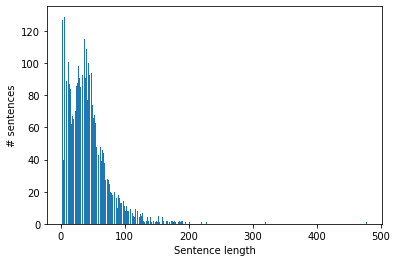

Traditional Chinese Training Data Info:


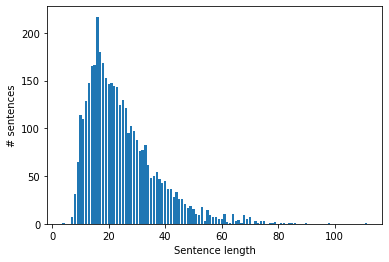

Finnish Training Data Info:


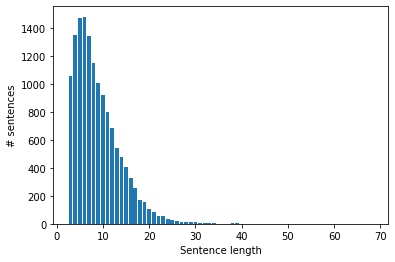

English Training Data Info:


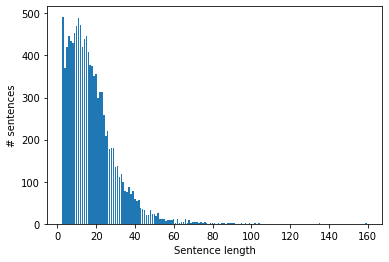

Hindi Training Data Info:


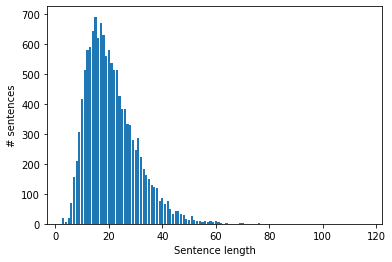

Persian Training Data Info:


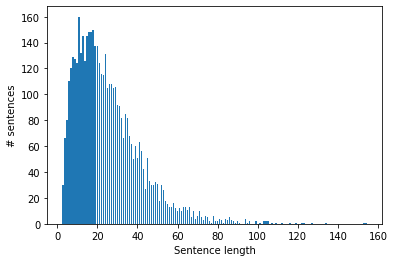

In [ ]:
arabic = "ar_padt-ud-train.conllu"
traditional_chinese = "zh_gsd-ud-train.conllu"
finnish = "fi_ftb-ud-train.conllu"
english = "en_ewt-ud-train.conllu"
hindi = "hi_hdtb-ud-train.conllu"
persian = "fa_seraji-ud-train.conllu"

dimdata = dict()
lydata = dict()
dimdata['Dimensions'] = []
dimdata['Language'] = []
dimdata['Accuracy'] = []

lydata['Layers'] = []
lydata['Language'] = []
lydata['Accuracy'] = []

np.arange(36, 117, 20)
np.arange(1, 12, 5)

def model_complexity_test(language_path, language_name):
    global dimdata, lydata
    language_lstm = pipeline(language_path)
    print(language_name, "Training Data Info:")
    language_lstm.trainingset_info()
    dim = list()
    ly = list()
    for n in range(0, 5):
        num = 36 + n*20
        language_lstm.create_model(WORD_EMBEDDING_DIM=num, HIDDEN_DIM=num, model_type='lstm', bidirectional=False, num_layers=1)
        language_lstm.training(batch_size=2000, n_epoch=4, optimizer='adam', lr=0.05, weight_decay=0)
        accuracy, sigma = language_lstm.mean_acc()
        dim.append(100*accuracy)
        dimdata['Dimensions'].append(num)
    dim = np.array(dim)
    name_list = np.array([language_name]*len(dim))
    dimdata['Accuracy'].extend(dim)
    dimdata['Language'].extend(name_list)
    
    for n in range(0, 4):
        num = 1 + 5*n
        language_lstm.create_model(WORD_EMBEDDING_DIM=36, HIDDEN_DIM=36, model_type='lstm', bidirectional=False, num_layers=num)
        language_lstm.training(batch_size=2000, n_epoch=4, optimizer='adam', lr=0.05, weight_decay=0)
        accuracy, sigma = language_lstm.mean_acc()
        ly.append(100*accuracy)
        lydata['Layers'].append(num)
    ly = np.array(ly)
    name_list = np.array([language_name]*len(ly))
    lydata['Accuracy'].extend(ly)
    lydata['Language'].extend(name_list)
    '''
    for i in range(len(wd)):
        print('word embed', str(dim[i]))
    
    for i in range(len(hd)):
        print('layer', str(ly[i]))
    '''
model_complexity_test(arabic, 'Arabic')
model_complexity_test(traditional_chinese, 'Traditional Chinese')
model_complexity_test(finnish, 'Finnish')
model_complexity_test(english, 'English')
model_complexity_test(hindi, 'Hindi')
model_complexity_test(persian, 'Persian')

## Model Complexity V.S. Languages Results

Below is the accuracy test using different embedding dimension, hidden dimension and different layers for 6 different languages. Overall, Chinese, Hindi, Arabic and Persian receive significant improvements as the embedding/hidden dimension goes up. Finnish, however, flunctuates when the dimension goes up. For the number of layers, Hindi has the best performance when the layer is at 11, Chinese at 6, and Finnish at 6. Interestingly, English doesn't get affected much when the model complexity goes up. We can conclude that Chinese and Hindi needs greater model complexity in both layers and dimensions than English. And Persian and Arabic needs greater complexity in model dimensions in comparison to English.

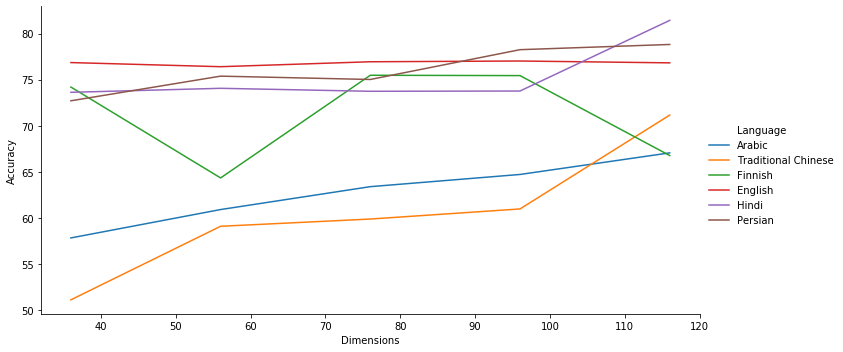

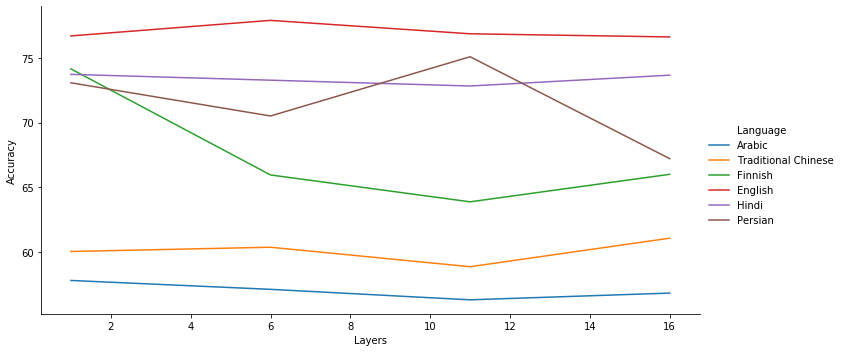

In [ ]:


df = pd.DataFrame(dimdata)
bf = pd.DataFrame(lydata)


# prepare plot
ax = sns.relplot(x='Dimensions', y='Accuracy', data=df,
                 hue='Language', kind='line', aspect=2)


bx = sns.relplot(x='Layers', y='Accuracy', data=bf,
                 hue='Language', kind='line', aspect=2)

## Shortcomings of the model

1. It might face the problem of vanishing or exploding gradients. Since the long-term information travel
long time and affects the present state, they might be corrupted by being multiplied 
several times by small or extremely large numbers. This is especially true in our model since  the initial 
parameter are set to zeros.
2. The model is too sensitive to the initial setting of the parameters.
3. It takes lots of time to manually adjust the hyperparameter, such as the number of layers
number of embedding, learning rates and choice of loss function. 
4. The model takes computing resources to process. It has four linear layer per cell,
which takes much computer memory.
5. The embedding of words is simple and ignores the sequence. Actually Pytorch's own embedding function 
 is a nearly linear one which takes the indices of the words and output vectors through lookuping a table 
that stores embeddings of a fixed dictionary and size. As a result, the models is sensitive to the 
embedding dimension layers on different languages.
6. Padding is introduced as part of data augmentation, filling the length of certain sentece with 
UNK. Yet when there are datasets with a small amount of long sentence and mostly medium
length-sentences. Then we get too many sparse matrix. 
 
how to improve:
1. We might introduce auto ML in the future, which serves to adjust the hyperparameters automatically and is more efficient.
2. We may implement better word embedding technique, which takes the sequence into consideration.  For example, pretrained contextual and non-contextual 
subword embeddings is effective in POS. It seperates the words into two morphemes, performs morpheme embedding  and combines them together.
(Sequence Tagging with Contextual and Non-Contextual Subword Representations: A Multilingual Evaluation)
3. BERT model can be adopted, which takes the word information, position information and sequence 
information into consideration.
4. We can adopt adversarial training as part of data augmentation to serve as regularizer and to improve robutness.
(Robust Multilingual Part-of-Speech Tagging via Adversarial Training)



## More on Weight Decay

Weight decay in Pytorch:
It is implemented in the optimizer module, in our case the adam optimizer.
To add weight decay in Pytorch, we simply set the parameter "weight_decay"  as 0.9 or other numbers.
In adam algorithm, weight decay is implemented as follows:


                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


If the weight decay is not zero, it works on weight updating in two aspects:


Firstly, the gradient at time t is the combination of derrivative of loss function at data in time t-1 and multiplication of data at time t-1 by weight decay.
In the code, we add the weight decay to the data element-wisely. 
Then exp_avg.mul_(beta1) is a matrix filled with product of (1-beta1) and gradient of data. exp_avg_sq.mul_(beta2) being the product of (1-beta2)*square of gradient

Secondly, when we update the weight, we reduce the original weight(when the weight decay is 0) by a product of learning rate\*weight decay\*weight at time t.
In the code, the program maintains the maximum of all 2ed moment running average till now.
Then it normalizes the runnign average of gradient by dividing the square of max number we got in the former step by the combination of square root of bias correction and eps variable. 
Note that eps is simply added to avoid the case that divisor is 0.
This normalized value is stored to a variable "denom".
In the end, denom is added to the weight in last moment combined with the step size and average exponential of gradient.